In [1]:
"""
Preparation
"""

import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
import utils

BASE_DIR = os.getcwd()
SEQ_DIR = os.path.join(os.getcwd(), "assets/real_data_1")
SEQ_SIZE = 122
OUTPUT_IMAGES_DIR = os.path.join(BASE_DIR, "output_images")

def print_cv_images(array, fig_weight, fig_height):
    if (len(array) < 2):
        raise ValueError
    table_height = len(array)
    table_weight = len(array[0])
    fig, table = plt.subplots(table_height, table_weight)
    fig.set_size_inches(fig_weight, fig_height)
    for row in range(table_height):
        for col in range(table_weight):
            table[row][col].imshow(cv.cvtColor(
                array[row][col],
                cv.COLOR_BGR2RGB),
            )

def get_file_number(n, k):
    res = str(n)
    while(len(res) < k):
        res = "0" + res
    return res

In [5]:
"""
Median blur + threshold + morphology opening
"""

thresh = 200

final_images = []
for ind in range(1, 9):
    image = cv.imread(f"assets/data_list_2/sample_{ind}.jpg")
    assert image is not None
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blured_image = cv.medianBlur(gray_image, 19)
    # blured_image = cv.GaussianBlur(gray_image, (5, 5), cv.BORDER_DEFAULT)
    ret, final_image = cv.threshold(
        blured_image,
        thresh,
        255,
        cv.THRESH_BINARY,
    )
    morphologed_image = cv.morphologyEx(final_image, cv.MORPH_OPEN, np.ones((19, 19), np.uint8))
    final_images.append((morphologed_image, final_image, blured_image))

In [4]:
THRESH = 200
final_images = []
for ind in range(0, 12):
    image = cv.imread(f"assets/data_list_3/frame_{get_file_number(ind, 2)}_delay-1s.jpg")
    assert image is not None
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blured_image = cv.medianBlur(gray_image, 19)
    # blured_image = cv.GaussianBlur(gray_image, (5, 5), cv.BORDER_DEFAULT)
    ret, final_image = cv.threshold(
        blured_image,
        THRESH,
        255,
        cv.THRESH_BINARY,
    )
    # morphologed_image = cv.morphologyEx(final_image, cv.MORPH_OPEN, np.ones((19, 19), np.uint8))
    final_images.append((cv.medianBlur(final_image, 31), final_image, blured_image))

In [ ]:
THRESH = 200
final_images = []
for ind in range(0, 12):
    image = cv.imread(f"assets/data_list_3/frame_{get_file_number(ind, 2)}_delay-1s.jpg")
    assert image is not None
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    ret, thresh_image = cv.threshold(
        gray_image,
        THRESH,
        255,
        cv.THRESH_BINARY,
    )
    contours, hierarchy = cv.findContours(thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # print(contours)
    gray_image_contours = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)
    cv.drawContours(gray_image_contours, contours, -1, (0, 0, 255), 3)

    final_images.append((gray_image_contours, thresh_image, image))

print_images(final_images, 10, 70)

In [3]:
K = 2
final_images = []
for ind in range(0, 12):
    image = cv.imread(f"assets/data_list_3/frame_{get_file_number(ind, 2)}_delay-1s.jpg")
    assert image is not None
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    Z = image.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)
    gray_final_image = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)
    final_images.append((gray_final_image, res2, image))

In [16]:
K = 2
MIN_DIST_GRAY = 40
final_images = []
for frame in range(SEQ_SIZE):
    image = cv.imread(os.path.join(SEQ_DIR, f"image_{frame}.png"))
    assert image is not None
    proc_image = np.float32(image.reshape((-1, 3)))
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.5)
    comp, labels, centers = cv.kmeans(proc_image, K, None, criteria, 30, cv.KMEANS_RANDOM_CENTERS)
    int_center = np.uint8(centers)
    gray_center = np.zeros(2, dtype=np.uint8)
    for i in range(len(int_center)):
        gray_center[i] = np.round(0.114 * int_center[i][0] + 0.587 * int_center[i][1] + 0.299 * int_center[i][2])
    if abs(np.int16(gray_center[0]) - np.int16(gray_center[1])) < MIN_DIST_GRAY:
        final_images.append(np.ones(image.shape[:2], dtype=bool))
    else:
        match_center = np.max(gray_center)
        res = int_center[labels.flatten()]
        res2 = res.reshape(image.shape)
        gray_final_image = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)
        final_images.append(gray_final_image == match_center)
mask = np.array(final_images)
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "wb") as f:
    np.save(f, mask)
print("Done")

Done


(122, 519, 452)


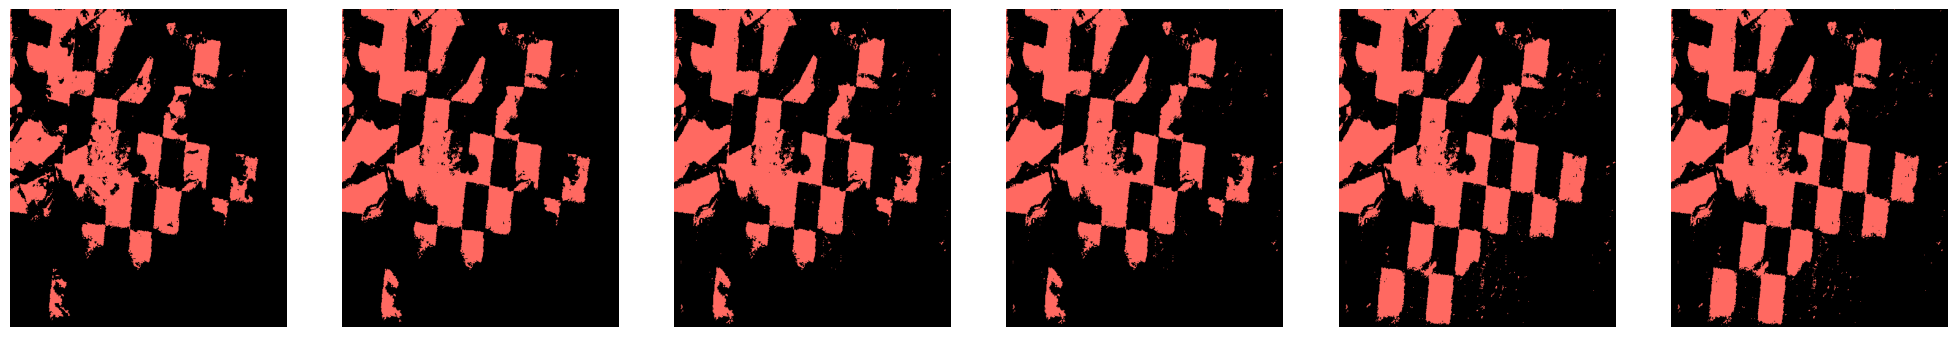

In [5]:
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "rb") as f:
    mask = np.load(f)
DELTA = 0
cnt = np.zeros(mask.shape[1:], dtype=np.uint16)
res = []
for i in range(SEQ_SIZE - 1, -1, -1):
    cnt += ~mask[i]
    res.append(cnt <= DELTA)
    # res.append(cv.cvtColor(np.uint8(cnt <= DELTA) * 255, v.COLOR_GRAY2RGB))
res = np.array(res[::-1])
print(res.shape)

utils.show_images(utils.images_to_rgb_mask(res[-6:]), fig_size=(25, 5))

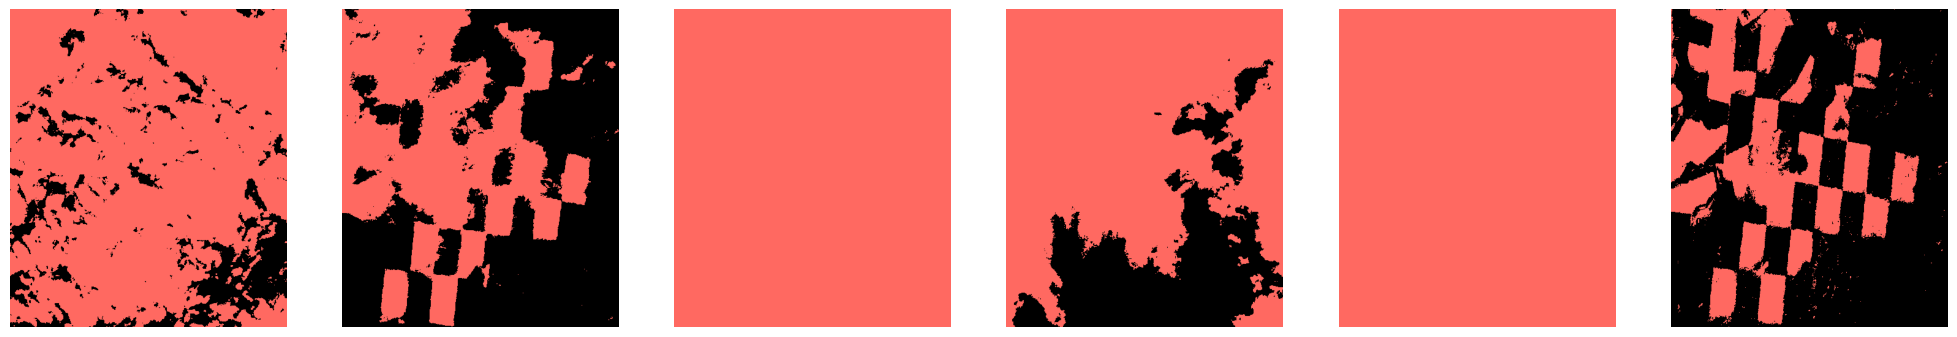

In [7]:
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "rb") as f:
    mask = np.load(f)
utils.show_images(utils.images_to_rgb_mask(mask[-6:]), fig_size=(25, 5))

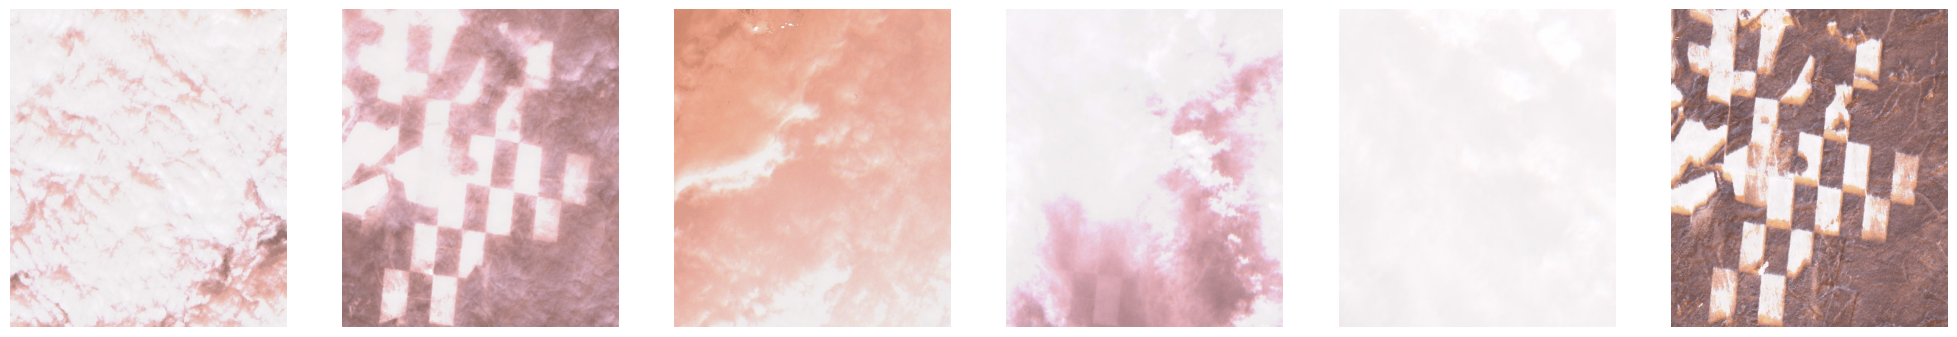

In [4]:
images = []
for frame in range(SEQ_SIZE):
    images.append(cv.imread(os.path.join(SEQ_DIR, f"image_{frame}.png")))
utils.show_images(np.array(images[-6:]), fig_size=(25, 5))

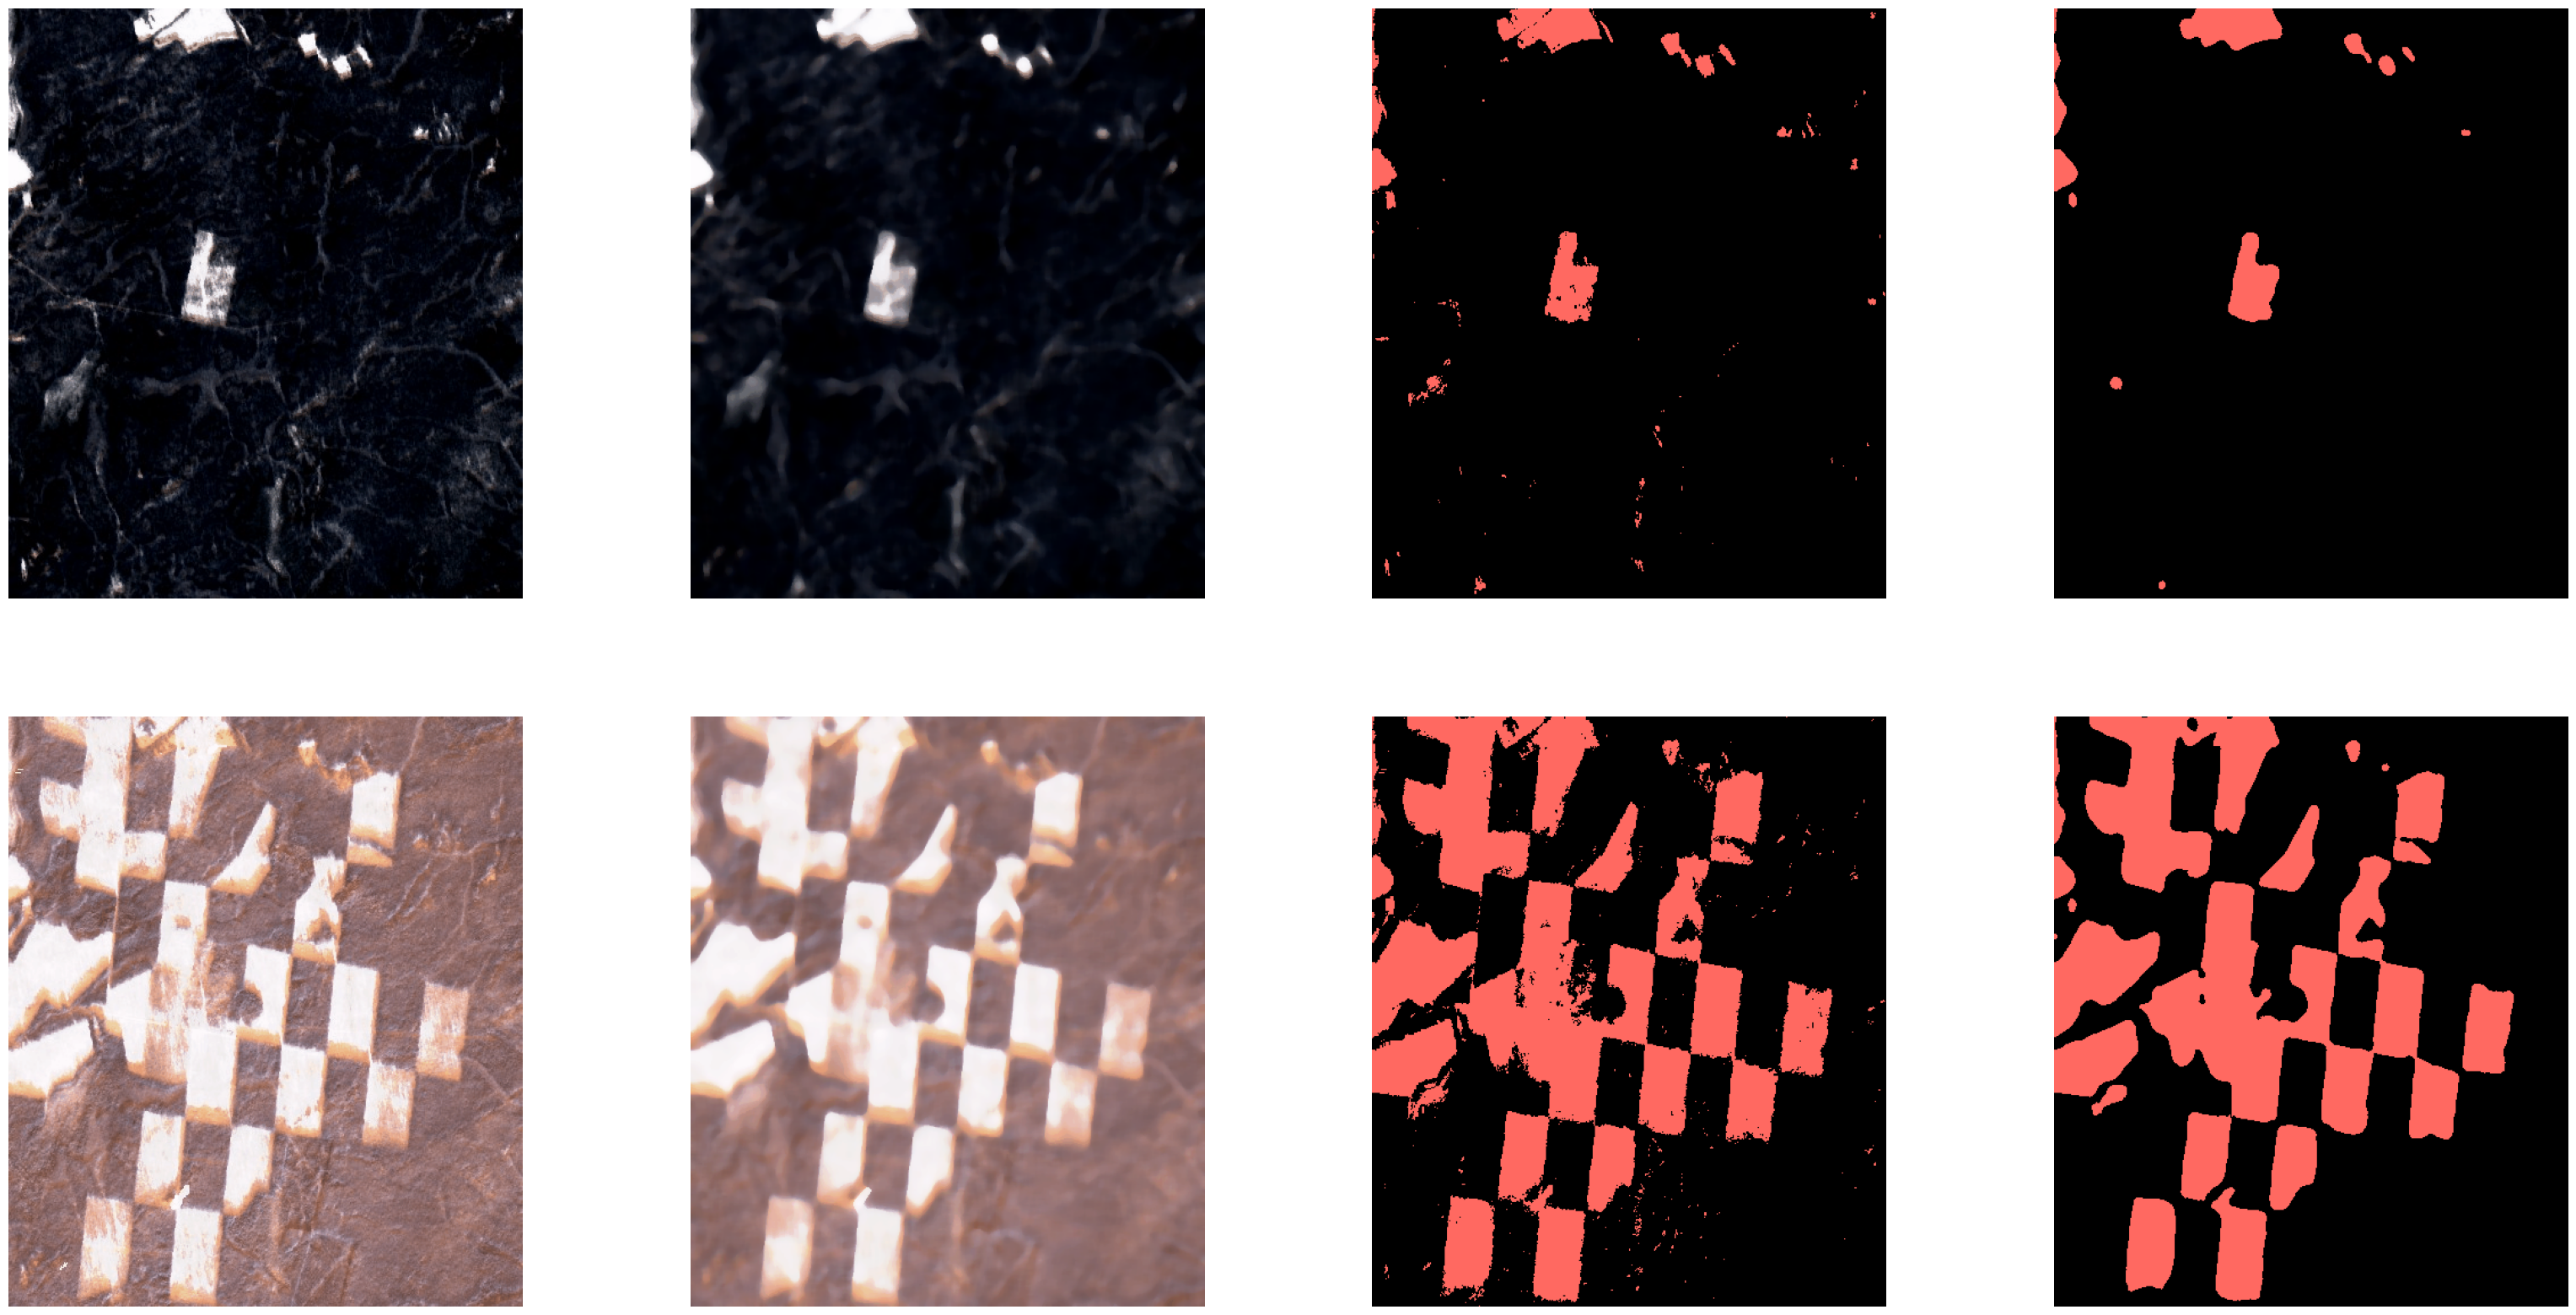

In [6]:
image_0 = cv.imread(os.path.join(SEQ_DIR, f"image_{3}.png"))
blurred_image_0 = cv.medianBlur(image_0, 9)
image_1 = cv.imread(os.path.join(SEQ_DIR, f"image_{SEQ_SIZE - 1}.png"))
blurred_image_1 = cv.medianBlur(image_1, 9)
pr_0 = utils.image_to_rgb_mask(utils.process_image(image_0))
pr_1 = utils.image_to_rgb_mask(utils.process_image(image_1))
res = np.array(
    [
        image_0,
        blurred_image_0,
        pr_0,
        utils.image_to_rgb_mask(utils.process_image(blurred_image_0)),
        image_1,
        blurred_image_1,
        pr_1,
        utils.image_to_rgb_mask(utils.process_image(blurred_image_1)),
    ]
)
utils.show_images(res, fig_size=(40, 20), row_size=4)

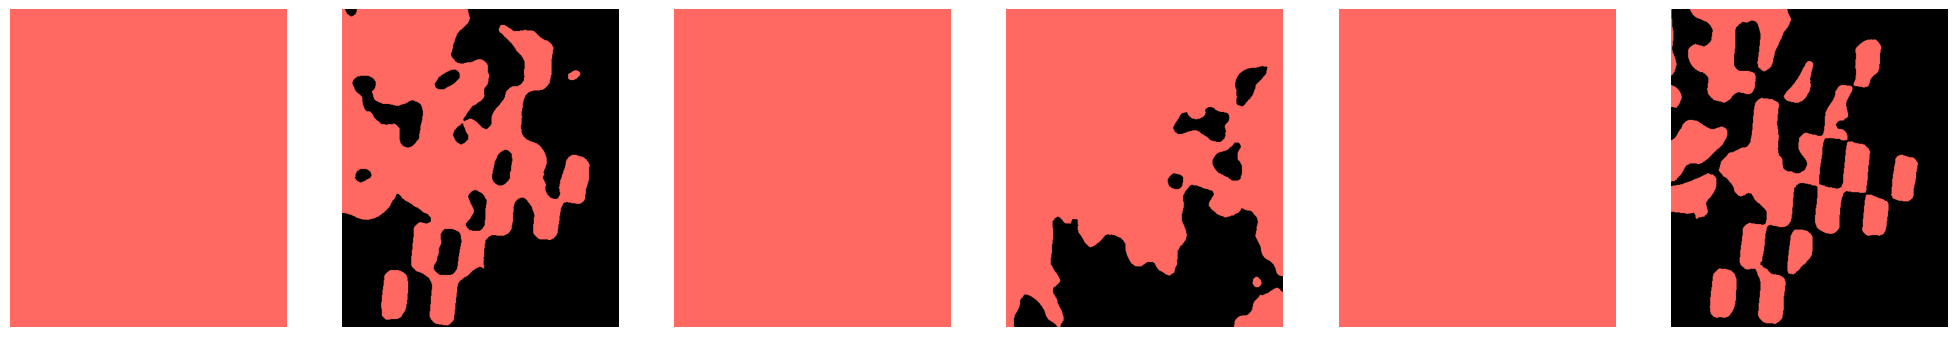

In [2]:
images_to_process = []
for frame in range(SEQ_SIZE):
    images_to_process.append(cv.imread(os.path.join(SEQ_DIR, f"image_{frame}.png")))
final_images = utils.process_images(np.array(images_to_process))
utils.show_images(utils.images_to_rgb_mask(final_images[-6:]), fig_size=(25, 5))
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "wb") as f:
    np.save(f, final_images)

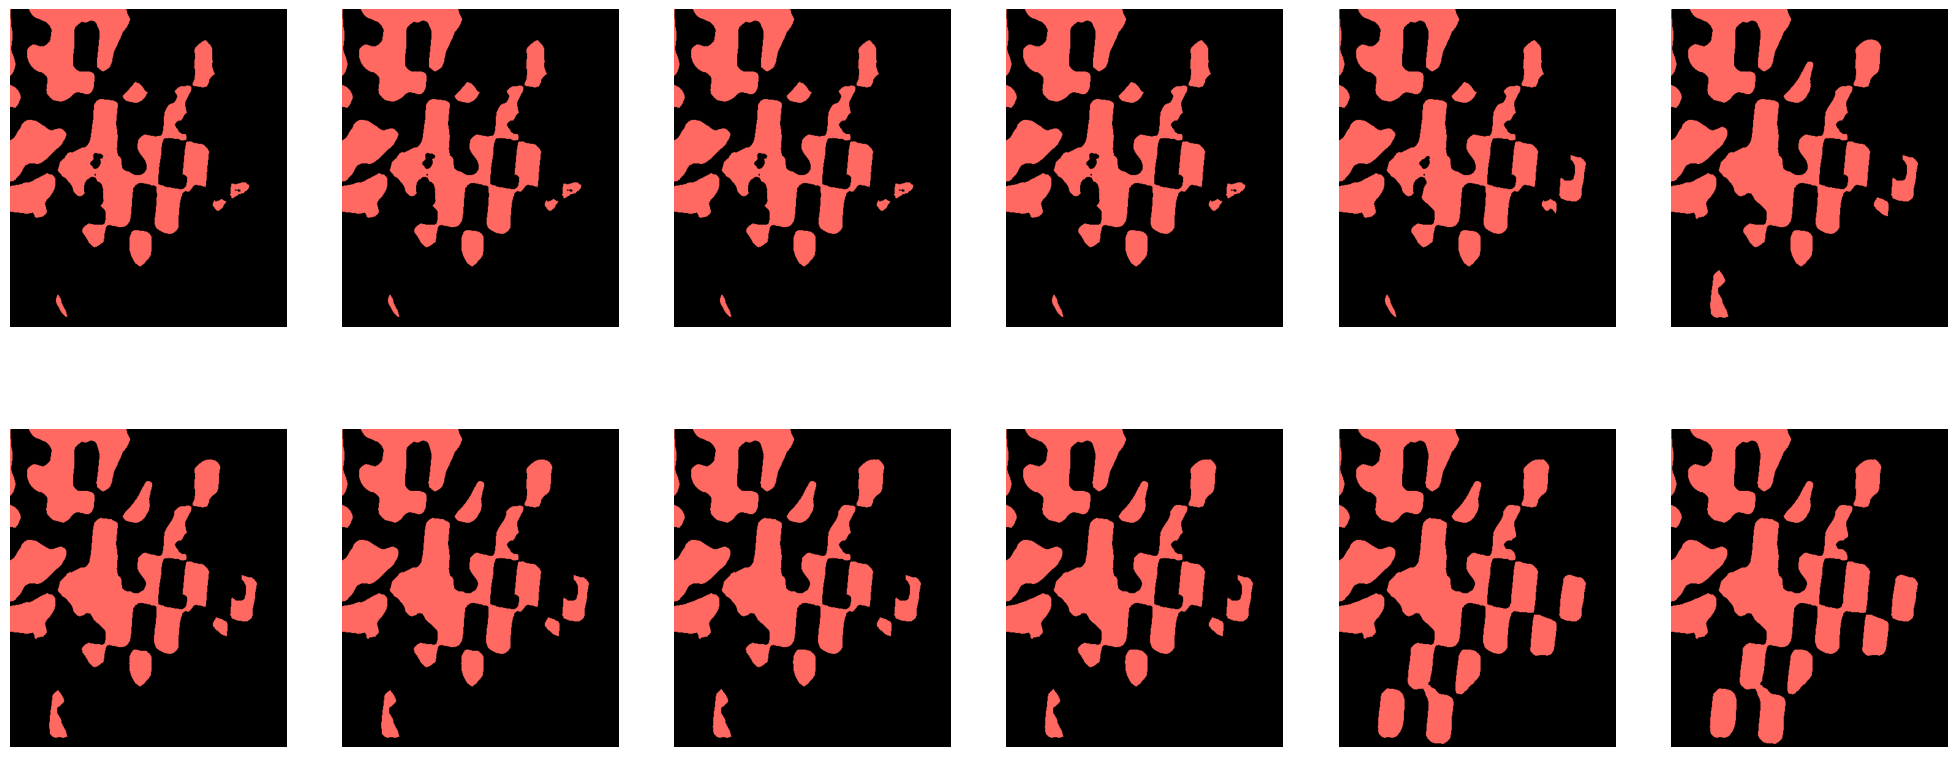

In [13]:
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "rb") as f:
    mask = np.load(f)
DELTA = 0
cnt = np.zeros(mask.shape[1:], dtype=np.uint16)
res = []
for i in range(SEQ_SIZE - 1, -1, -1):
    cnt += ~mask[i]
    res.append(cnt <= DELTA)
res = np.array(res[::-1])
utils.show_images(utils.images_to_rgb_mask(res[-12:]), fig_size=(25, 10))

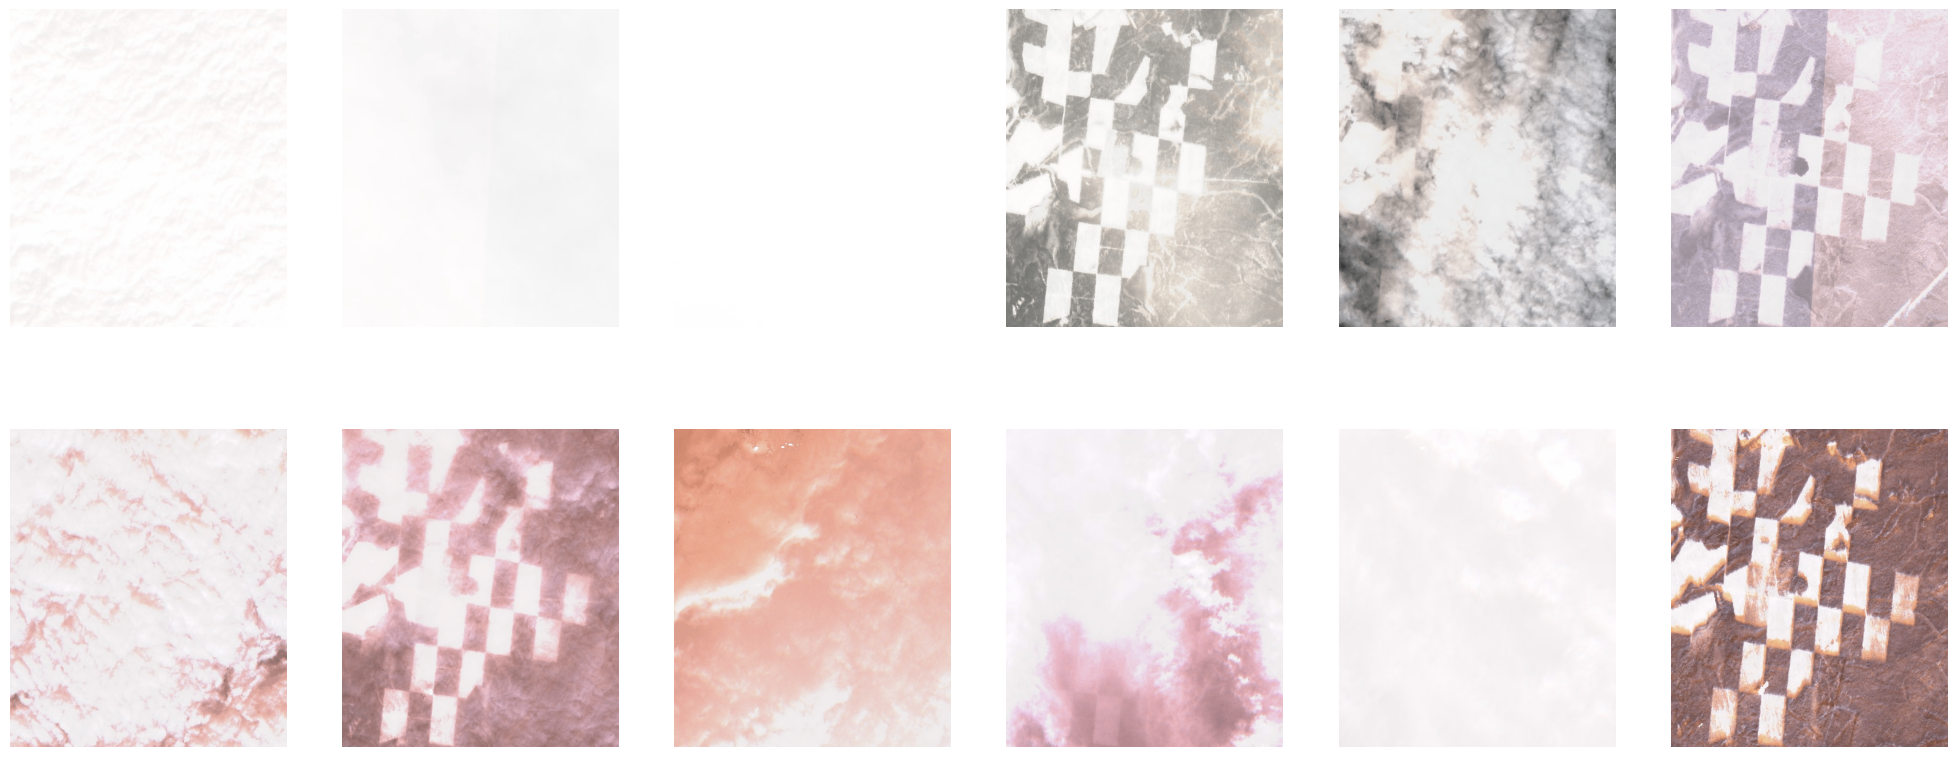

In [9]:
images = []
for frame in range(SEQ_SIZE):
    images.append(cv.imread(os.path.join(SEQ_DIR, f"image_{frame}.png")))
utils.show_images(np.array(images[-12:]), fig_size=(25, 10))

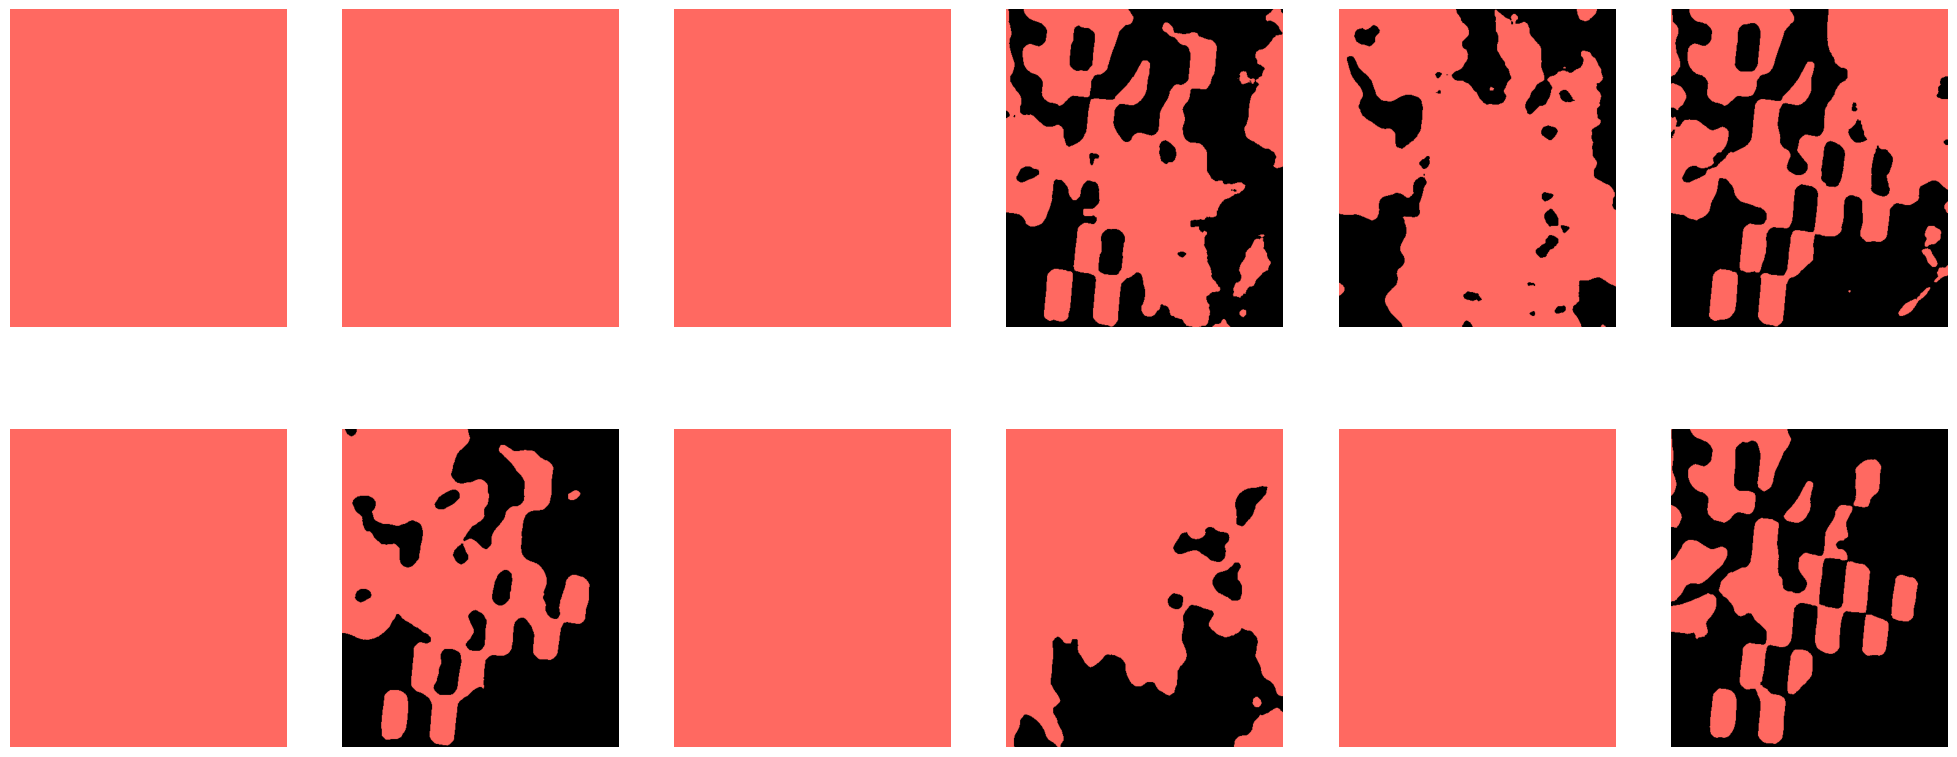

In [11]:
with open(os.path.join(OUTPUT_IMAGES_DIR, "mask_save.npy"), "rb") as f:
    mask = np.load(f)
utils.show_images(utils.images_to_rgb_mask(mask[-12:]), fig_size=(25, 10))